In [17]:
import torch
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [18]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)

In [19]:
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))

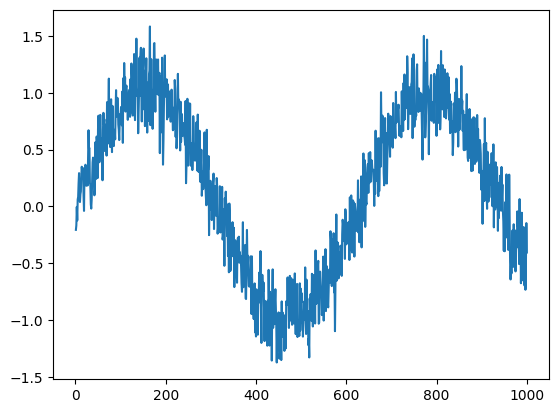

In [20]:
plt.plot(time, x)

In [ ]:
0123 4
1234
996 997 998 999

In [21]:
tau=4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T-tau+i]
labels=x[tau:].reshape(-1,1)


batch_size=16
n_train=600a

In [22]:
def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential=nn.Sequential(
            nn.Linear(4, 10)
            ,nn.ReLU()
            ,nn.Linear(10, 1))
        self.sequential.apply(init_weights)
    def forward(self,x):
        return self.sequential(x)

In [23]:
class TimeDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data            # 数据路径或数据本身
        self.labels = labels         # 标签
        self.transform = transform  # 数据预处理（如transforms.Compose）

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [24]:
data=TimeDataset(features[:600], labels[:600])
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
loss=nn.MSELoss(reduction='none')

In [25]:
def train(model, train_iter, loss, epoch, lr):
    trainer=torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epoch):
        for x,y in train_iter:
            trainer.zero_grad()
            y_hat=model(x)
            l=loss(y_hat, y)
            l.sum().backward()
            trainer.step()
        
        loss_eval=0
        for x,y in train_iter:
            loss_eval+=loss(model(x), y).sum()
        
        print(f'epoch {epoch + 1}, '
              f'loss: {loss_eval})')
    

In [26]:
net=Net()

In [27]:
train(net,dataloader,loss,5,lr=0.01)

epoch 1, loss: 36.64963150024414)
epoch 2, loss: 31.3748779296875)
epoch 3, loss: 30.236907958984375)
epoch 4, loss: 29.401134490966797)
epoch 5, loss: 30.778852462768555)


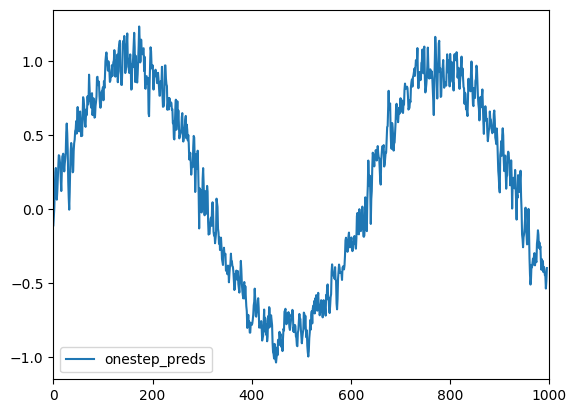

In [28]:
plt.plot(net(features).detach().numpy())
plt.legend(['onestep_preds'])
plt.xlim([0,1000])
plt.show()

In [29]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

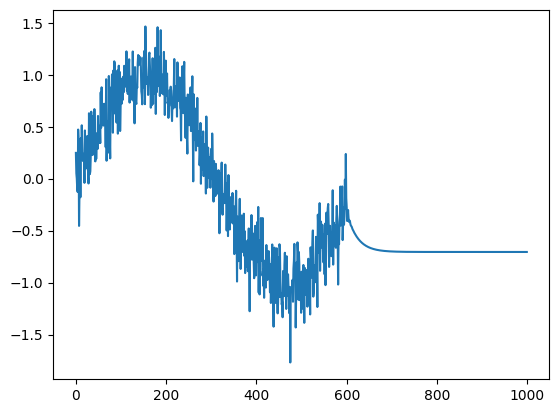

In [14]:
plt.plot(multistep_preds.detach().numpy())
##这个地方出错是正常的

In [32]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是第（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

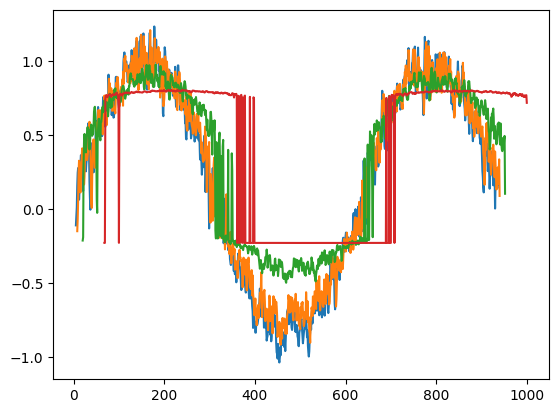

In [47]:
steps = (1, 4, 16, 64)
for i in steps:
    plt.plot(time[tau + i - 1: T - max_steps + i].detach().numpy(),
             features[:, (tau + i - 1)].detach().numpy())

In [187]:
import collections
import re
import requests
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [189]:
DATA_HUB['time_machine'] = ('http://d2l-data.s3-accelerate.amazonaws.com/'+ 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

In [190]:
DATA_HUB['time_machine']

('http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt',
 '090b5e7e70c295757f55df93cb0a180b9691891a')

In [191]:
r = requests.get(DATA_HUB['time_machine'][0], stream=True, verify=True)

In [194]:
f=open('../data/time_machine.txt', 'wb')
f.write(r.content)
f.close()

In [201]:
with open('../data/time_machine.txt', 'r',encoding='utf-8') as f:
    lines=f.readlines()
    result=[re.sub('[^A-Za-z]', ' ', line).strip().lower() for line in lines]

In [204]:
lines = result
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine  by h  g  wells
twinkled  and his usually pale face was flushed and animated  the


# 词元化

In [205]:
lines

['the time machine  by h  g  wells',
 '',
 '',
 '',
 '',
 'i',
 '',
 '',
 'the time traveller  for so it will be convenient to speak of him',
 'was expounding a recondite matter to us  his grey eyes shone and',
 'twinkled  and his usually pale face was flushed and animated  the',
 'fire burned brightly  and the soft radiance of the incandescent',
 'lights in the lilies of silver caught the bubbles that flashed and',
 'passed in our glasses  our chairs  being his patents  embraced and',
 'caressed us rather than submitted to be sat upon  and there was that',
 'luxurious after dinner atmosphere when thought roams gracefully',
 'free of the trammels of precision  and he put it to us in this',
 'way  marking the points with a lean forefinger  as we sat and lazily',
 'admired his earnestness over this new paradox  as we thought it',
 'and his fecundity',
 '',
 'you must follow me carefully  i shall have to controvert one or two',
 'ideas that are almost universally accepted  the geometry  f

In [209]:
def tokenize(text,token='word'):
    if token == 'word':
        return [i.split() for i in text]
    if token == 'char':
        return [list(line) for line in text]
    else:
        print('wrong token')

In [277]:
tokens = tokenize(lines)
tokens[0]

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']

In [280]:
def count_corpus(tokens):
    '''统计词元频率'''
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

## 词表
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0,如果有其他的特殊标记词 则unk放在其他词前面
        self.idx_to_token = ['<unk>'] + reserved_tokens
        # 整理标记词的token to idx
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        
        # 整理所有满足条件的词
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
        
        

In [281]:
v=Vocab(tokens)

In [282]:
v.idx_to_token


['<unk>',
 'the',
 'i',
 'and',
 'of',
 'a',
 'to',
 'was',
 'in',
 'that',
 'my',
 'it',
 'had',
 'me',
 'as',
 'at',
 'for',
 'with',
 'but',
 'time',
 'were',
 'this',
 'you',
 'on',
 'then',
 'his',
 'there',
 'he',
 'have',
 'they',
 'from',
 'one',
 'all',
 'not',
 'into',
 'upon',
 'little',
 'so',
 'is',
 'came',
 'by',
 'some',
 'be',
 'no',
 'could',
 'their',
 'said',
 'saw',
 'down',
 'them',
 'machine',
 'which',
 'very',
 'or',
 'an',
 'we',
 'now',
 'what',
 'been',
 'these',
 'like',
 'her',
 'out',
 'seemed',
 'up',
 'man',
 'about',
 's',
 'its',
 'thing',
 'again',
 'traveller',
 'would',
 'more',
 'white',
 'our',
 'thought',
 'felt',
 'when',
 'over',
 'weena',
 'still',
 'world',
 'myself',
 'even',
 'must',
 'through',
 'if',
 'hand',
 'went',
 'first',
 'are',
 'before',
 'last',
 'towards',
 'only',
 'people',
 'she',
 'morlocks',
 'see',
 'too',
 'found',
 'how',
 'here',
 'light',
 'great',
 'under',
 'did',
 'him',
 'any',
 'began',
 'back',
 'night',
 'face

In [283]:
v.token_to_idx

{'<unk>': 0,
 'the': 1,
 'i': 2,
 'and': 3,
 'of': 4,
 'a': 5,
 'to': 6,
 'was': 7,
 'in': 8,
 'that': 9,
 'my': 10,
 'it': 11,
 'had': 12,
 'me': 13,
 'as': 14,
 'at': 15,
 'for': 16,
 'with': 17,
 'but': 18,
 'time': 19,
 'were': 20,
 'this': 21,
 'you': 22,
 'on': 23,
 'then': 24,
 'his': 25,
 'there': 26,
 'he': 27,
 'have': 28,
 'they': 29,
 'from': 30,
 'one': 31,
 'all': 32,
 'not': 33,
 'into': 34,
 'upon': 35,
 'little': 36,
 'so': 37,
 'is': 38,
 'came': 39,
 'by': 40,
 'some': 41,
 'be': 42,
 'no': 43,
 'could': 44,
 'their': 45,
 'said': 46,
 'saw': 47,
 'down': 48,
 'them': 49,
 'machine': 50,
 'which': 51,
 'very': 52,
 'or': 53,
 'an': 54,
 'we': 55,
 'now': 56,
 'what': 57,
 'been': 58,
 'these': 59,
 'like': 60,
 'her': 61,
 'out': 62,
 'seemed': 63,
 'up': 64,
 'man': 65,
 'about': 66,
 's': 67,
 'its': 68,
 'thing': 69,
 'again': 70,
 'traveller': 71,
 'would': 72,
 'more': 73,
 'white': 74,
 'our': 75,
 'thought': 76,
 'felt': 77,
 'when': 78,
 'over': 79,
 'weena':

In [233]:
r=count_corpus(tokens)

In [239]:
reserved_tokens=sorted(r.items(), key=lambda x: x[1], reverse=True)

In [241]:
idx_to_token = ['<unk>'] + reserved_tokens

In [255]:
token_to_idx ={token: idx for idx, token in enumerate(idx_to_token)}

In [256]:
token_to_idx

{'<unk>': 0,
 ('the', 2261): 1,
 ('i', 1267): 2,
 ('and', 1245): 3,
 ('of', 1155): 4,
 ('a', 816): 5,
 ('to', 695): 6,
 ('was', 552): 7,
 ('in', 541): 8,
 ('that', 443): 9,
 ('my', 440): 10,
 ('it', 437): 11,
 ('had', 354): 12,
 ('me', 281): 13,
 ('as', 270): 14,
 ('at', 243): 15,
 ('for', 221): 16,
 ('with', 216): 17,
 ('but', 204): 18,
 ('time', 200): 19,
 ('were', 158): 20,
 ('this', 152): 21,
 ('you', 137): 22,
 ('on', 137): 23,
 ('then', 134): 24,
 ('his', 129): 25,
 ('there', 127): 26,
 ('he', 123): 27,
 ('have', 122): 28,
 ('they', 122): 29,
 ('from', 122): 30,
 ('one', 120): 31,
 ('all', 118): 32,
 ('not', 114): 33,
 ('into', 114): 34,
 ('upon', 113): 35,
 ('little', 113): 36,
 ('so', 112): 37,
 ('is', 106): 38,
 ('came', 105): 39,
 ('by', 103): 40,
 ('some', 94): 41,
 ('be', 93): 42,
 ('no', 92): 43,
 ('could', 92): 44,
 ('their', 91): 45,
 ('said', 89): 46,
 ('saw', 88): 47,
 ('down', 87): 48,
 ('them', 86): 49,
 ('machine', 85): 50,
 ('which', 85): 51,
 ('very', 85): 52,
 ('

In [258]:
for token, freq in reserved_tokens:
    if freq < 100:
        break
    if token not in token_to_idx:
        idx_to_token.append(token)
        token_to_idx[token] = len(idx_to_token) - 1

In [265]:
token_to_idx.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21